In [1]:
import numpy as np
from pathlib import Path
from keras.preprocessing import image 
import matplotlib.pyplot as plt


In [2]:
p=Path('../desktop/dataset')

In [3]:
dirs=p.glob("*")

In [4]:
image_data=[]
labels=[]
for folder_path in dirs:
    pokemon_name=str(folder_path).split('\\')[-1]
    for img_path in folder_path.glob('*.jpg'):
        img=image.load_img(img_path,target_size=(32,32))
        img_array=image.img_to_array(img)
        labels.append(pokemon_name)
        image_data.append(img_array)
    
    

#DATA VISUALIZATION

In [5]:
len(labels),len(image_data)

(706, 706)

In [6]:
def draw(im):
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    

In [7]:
image_data=np.array(image_data,dtype='float32')/255

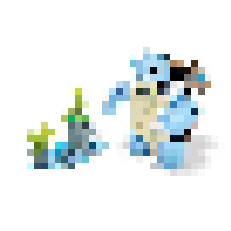

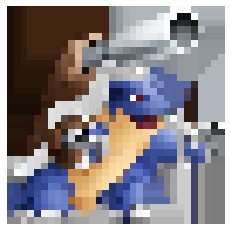

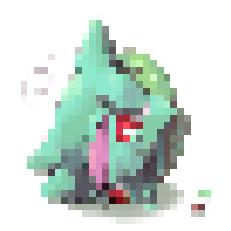

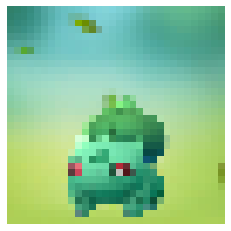

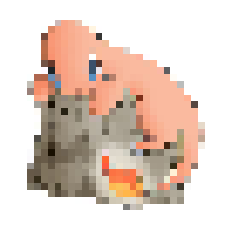

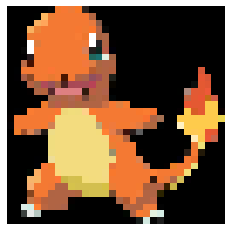

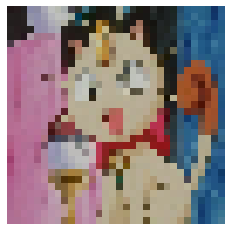

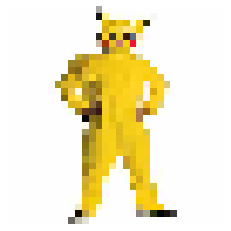

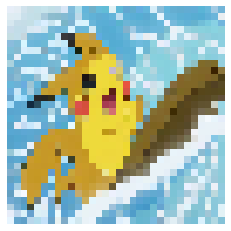

In [8]:
ind=[5,50,100,200,250,400,450,650,700]
for i in ind:
    draw(image_data[i])


#FLATTENING THE IMAGE

In [9]:
m=image_data.shape[0]
image_data=image_data.reshape((m,-1))
image_data.shape

(706, 3072)

In [10]:
labels=np.array(labels)
labels=labels.reshape((-1,1))

#SHUFFLING THE DATA

In [11]:
shuffled_data=np.hstack((labels,image_data))
np.random.shuffle(shuffled_data)

In [12]:
labels=shuffled_data[:,0]
image_data=shuffled_data[:,1:]
image_data.shape,labels.shape

((706, 3072), (706,))

In [13]:
image_data=np.array(image_data,dtype='float32')


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train,x_test,y_train,y_test=train_test_split(image_data,labels.reshape(-1,1))

In [16]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((529, 3072), (529, 1), (177, 3072), (177, 1))

#MY MLP CODE

In [17]:
def softmax(a):
    ea = np.exp(a)
    return ea/np.sum(ea,axis=1,keepdims=True)

In [18]:
class NeuralNetwork:
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        model = {}
        model['W1'] = np.random.randn(input_size,layers[0]) 
        model['b1'] = np.zeros((1,layers[0]))
        
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        model['W3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        
    def forward(self,x):

        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1,W2) + b2 
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3) + b3
        y_ = softmax(z3)
        
        #Store the outputs of each layer for back-propagation
        self.activation_outputs = (a1,a2,y_)
        
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        delta3 = y_ - y
        
        dw3 = np.dot(a2.T,delta3) #)h2+1,C) => (h2+1,m) X (m,C) 
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)  #(m,h2+1) => (m,h2+1) *(m,C X C,h2+1)
        dw2 = np.dot(a1.T,delta2)  
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T) 
        dw1 = np.dot(x.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        self.model['W1'] -= learning_rate*dw1
        self.model['W2'] -= learning_rate*dw2
        self.model['W3'] -= learning_rate*dw3
        
        self.model['b1'] -= learning_rate*db1
        self.model['b2'] -= learning_rate*db2
        self.model['b3'] -= learning_rate*db3
        
        
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)
        
        print("W2 ",W2.shape)
        print("A2 ",a2.shape)
        
        print("W3 ",W3.shape)
        print("Y_ ",y_.shape)
        

In [19]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l    

def one_hot(y,depth):
    m = y.shape[0]
    y_oht = np.zeros((m, depth))
    y_oht[np.arange(m), y] = 1
    return y_oht

In [20]:
def train(X,Y,model,epochs,logs=True):
    """Creates and Model and Trains it!"""
    
    training_loss = []
    val_loss = []
    val_acc = []
    
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        model.backward(X,Y_OHT)
        training_loss.append(l)
        if(logs and ix%50==0):            
            print("Epoch %d loss %.4f"%(ix,l))
    return training_loss    

In [21]:
model= NeuralNetwork(input_size=3072,layers=[100,50],output_size=5)

In [22]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
y_train=le.fit_transform(y_train)

C:\Users\91763\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [23]:
res=train(x_train,y_train,model,1000,0.0001)

Epoch 0 loss 1.4322
Epoch 50 loss 0.7262
Epoch 100 loss 0.2311
Epoch 150 loss 0.2330
Epoch 200 loss 0.3279
Epoch 250 loss 0.1959
Epoch 300 loss 0.1586
Epoch 350 loss 0.1433
Epoch 400 loss 0.1453
Epoch 450 loss 0.0343
Epoch 500 loss 0.0280
Epoch 550 loss 0.0327
Epoch 600 loss 0.0192
Epoch 650 loss 0.0146
Epoch 700 loss 0.0122
Epoch 750 loss 0.0106
Epoch 800 loss 0.0093
Epoch 850 loss 0.0085
Epoch 900 loss 0.0077
Epoch 950 loss 0.0071


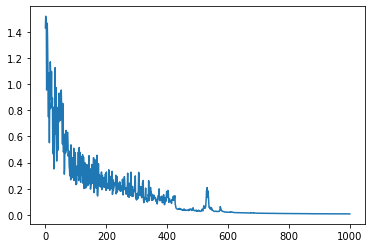

In [24]:
plt.plot(res)

In [25]:
preds=model.predict(x_test)
preds=le.inverse_transform(preds)

In [26]:
preds=preds.reshape(-1,1)

In [27]:
y_test.shape

(177, 1)

In [48]:
#TESTING ACCURACY

np.sum(preds==y_test)/y_test.shape[0]

0.5988700564971752

In [29]:
tpred=model.predict(x_train)
tpred.shape

(529,)

In [30]:
y_train.shape

(529,)

#TRAINING ACCURACY

In [37]:
np.sum(tpred==y_train)/y_train.shape[0]

0.9905482041587902

In [39]:
from sklearn.metrics import confusion_matrix

In [47]:
cnf_matrix=confusion_matrix(tpred,y_train)
cnf_matrix

array([[ 49,   0,   0,   0,   0],
       [  0, 130,   1,   0,   0],
       [  0,   1, 156,   0,   1],
       [  0,   0,   0,  48,   0],
       [  0,   0,   1,   1, 141]], dtype=int64)